In [1]:
import preprocess
import numpy as np
import glob
import os
import random
import keras
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
import cv2
# from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D, Concatenate
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from tensorflow.keras.models import Sequential
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

PATH_TRAIN = '/home/deepenoughlearning/ImageSegmentation/preprocessed'
PATH_TRAIN_IMAGES = '/home/deepenoughlearning/ImageSegmentation/preprocessed/original'
PATH_TRAIN_MASKS = '/home/deepenoughlearning/ImageSegmentation/preprocessed/mask'

smooth = 1.


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)


# Custom IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)


def data_gen(img_folder, mask_folder, batchsize):
    num_training_images = os.listdir(img_folder)
    random.shuffle(num_training_images)  # then what happens to the mask folder?
    # it's necessary for yield
    start = 0
    while (True):
        img = np.zeros((batchsize, 1040, 2000, 1)).astype('float')
        mask = np.zeros((batchsize, 1040, 2000, 1)).astype('float')
        for i in range(start, batchsize):
            train_img = cv2.imread(img_folder + '/' + num_training_images[i], cv2.IMREAD_GRAYSCALE) / 255.
            img[i - start] = train_img
            train_mask = cv2.imread(mask_folder + '/' + num_training_images[i], cv2.IMREAD_GRAYSCALE) / 255.
            mask[i - start] = train_mask

        start += batchsize
        if (start + batchsize >= len(num_training_images)):
            start = 0
            random.shuffle(num_training_images)

        yield img, mask


Using TensorFlow backend.


In [5]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/home/deepenoughlearning/keract')


In [2]:
def get_unet(img_rows, img_cols):
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='conv2d1')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='conv2d2')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), name='maxpooling2d1')(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='conv2d3')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='conv2d4')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), name='maxpooling2d2')(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='conv2d5')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='conv2d6')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), name='maxpooling2d3')(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='conv2d7')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='conv2d8')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), name='maxpooling2d4')(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='conv2d9')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='conv2d10')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal', name='upsampleconv2d1')(
        UpSampling2D(size=(2, 2), name='upsampling2d1')(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='mergeconv2d1')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='mergeconv2d2')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal', name='upsampleconv2d2')(
        UpSampling2D(size=(2, 2), name='upsampling2d2')(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='mergeconv2d3')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='mergeconv2d4')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal', name='upsampleconv2d3')(
        UpSampling2D(size=(2, 2), name='upsampling2d3')(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='mergeconv2d5')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='mergeconv2d6')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal', name='upsampleconv2d4')(
        UpSampling2D(size=(2, 2), name='upsampling2d4')(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='mergeconv2d7')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='mergeconv2d8')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='mergeconv2d9')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid', name='mergeconv2d10')(conv9)

    model = Model(input=inputs, output=conv10)
    model.compile(optimizer=Adam(lr=1e-5), loss=bce_dice_loss, metrics=[dice_coef_loss])

    return model

model = get_unet(1040, 2000)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("me...)`


In [5]:
print("one")
image_datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   rotation_range=10
                                   )
print("two")
mask_datagen = ImageDataGenerator(horizontal_flip=True,
                                  vertical_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  zoom_range=0.1,
                                  rotation_range=10
                                  )
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1

filelist_images = glob.glob(os.path.join(PATH_TRAIN + '/original/cavity/', '*.jpg'))
filelist_masks = glob.glob(os.path.join(PATH_TRAIN + '/mask/cavity/', '*.jpg'))

filelist_images = preprocess.quicksort(filelist_images)
filelist_masks = preprocess.quicksort(filelist_masks)

train_loaded_images = []
train_loaded_masks = []

for image in filelist_images:
    img = cv2.imread(image, 0)  # reading grayscale images. without it, it will have 3 color channels
    newimg = np.zeros((1040, 2000, 1), dtype=int)
    newimg[:, :, 0] = img[:, :]
    train_loaded_images.append(newimg)

train_loaded_images = np.array(train_loaded_images)

print("suhyun")
print(train_loaded_images.shape)

for mask in filelist_masks:
    newimg = np.zeros((1040, 2000, 1), dtype=int)
    msk = cv2.imread(mask, 0)
    newimg[:, :, 0] = msk[:, :]
    train_loaded_masks.append(newimg)

    
print("three")
image_datagen.fit(train_loaded_images, augment=True, seed=seed)
print("four")
mask_datagen.fit(train_loaded_masks, augment=True, seed=seed)

print("five")

image_generator = image_datagen.flow_from_directory(
    batch_size=1,
    directory=PATH_TRAIN_IMAGES,
    class_mode=None,
    target_size=(1040, 2000),
    color_mode='grayscale'
)
print("six")

mask_generator = mask_datagen.flow_from_directory(
    batch_size=1,
    directory=PATH_TRAIN_MASKS,
    class_mode=None,
    target_size=(1040, 2000),
    color_mode='grayscale'
)

print("seven")

train_generator = zip(image_generator, mask_generator)

print("eight")

# steps_per_epoch = number of batch iterations before a training epoch is considered finished.
batch_size = 1

from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, mode='min', verbose=1)
checkpoint = ModelCheckpoint('unet-7-27.h5', monitor='loss', verbose=1, save_best_only=True)

model.fit_generator(
    train_generator,
    validation_steps=2, steps_per_epoch=len(train_loaded_images) / (batch_size * 2), epochs=5,
    callbacks=[early_stop, checkpoint]
)

model.save_weights("unet-8-7.h5")

one
two
suhyun
(196, 1040, 2000, 1)
three
four
five
Found 196 images belonging to 1 classes.
six
Found 196 images belonging to 1 classes.
seven
eight
Instructions for updating:
Use tf.cast instead.


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("me...)`


Epoch 1/5
98/98 [==============================] - 142s 1s/step - loss: 5.4319 - dice_coef_loss: 0.9470

Epoch 00001: loss improved from inf to 5.43190, saving model to unet-7-27.h5
Epoch 2/5
98/98 [==============================] - 120s 1s/step - loss: 4.8870 - dice_coef_loss: 0.9809

Epoch 00002: loss improved from 5.43190 to 4.88699, saving model to unet-7-27.h5
Epoch 3/5
98/98 [==============================] - 120s 1s/step - loss: 4.9558 - dice_coef_loss: 0.9704

Epoch 00003: loss did not improve from 4.88699
Epoch 4/5
98/98 [==============================] - 120s 1s/step - loss: -0.0904 - dice_coef_loss: 0.5512

Epoch 00004: loss improved from 4.88699 to -0.09044, saving model to unet-7-27.h5
Epoch 5/5
98/98 [==============================] - 120s 1s/step - loss: -0.0595 - dice_coef_loss: 0.5701

Epoch 00005: loss did not improve from -0.09044


In [3]:
model.load_weights('unet-7-27.h5')
img = np.zeros((1, 1040, 2000, 1), dtype=int)

In [4]:
train_img = cv2.imread(PATH_TRAIN_IMAGES + '/cavity/' + "186.jpg", 0)
    
img[0, :, :, 0] = train_img

In [5]:
print(img.shape)
print(train_img.shape)

(1, 1040, 2000, 1)
(1040, 2000)


In [15]:
from keract import get_activations
activations = get_activations(model, img)

InternalError: Could not allocate ndarray

In [8]:
activations = model.predict(img, verbose=1)
print(activations.shape)

1/1 [==============================] - 0s 409ms/step
(1, 1040, 2000, 1)


In [7]:
first_layer_activation = activations[1]
print(first_layer_activation.shape)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
model.get_layer("upsampling2d1")

1/1 [==============================] - 0s 398ms/step
nine
(1040, 2000)


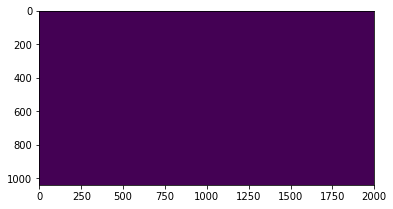

In [54]:
def plot_sample(X):
    newx = np.zeros((1040, 2000), dtype=int)
    newx[:, :] = X[0, :, :, 0]
    print(newx.shape)
    xplot = plt.imshow(newx)


mask = np.zeros((1, 1040, 2000, 1), dtype=int)
mask_img = cv2.imread(PATH_TRAIN_MASKS + '/cavity/' + "109.jpg", 0)
mask[0, :, :, 0] = mask_img

print("nine")

plot_sample(preds_train)